In [1]:
import numpy as np
import math
from fractions import Fraction
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
import os
import matplotlib
from matplotlib.colors import Normalize,FuncNorm,LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from haversine import haversine, Unit
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from matplotlib.ticker import FixedLocator,FuncFormatter

In [2]:
max_process=20 # The maximum number of parallel process

In [3]:
# Astronomy-related constants

TE = 24 * 3600  # One Earth sidereal day in seconds

RE = 6371e3  # Mean radius of Earth in meters

u = 3.986e14  # Standard gravitational parameter (μ = GM) in m^3/s^2

K = RE / pow(u, 1/3) * pow(2 * np.pi, 2/3)  

eps = 25 * np.pi / 180  # Maximum elevation angle for ground access, in radians (25°)


In [4]:
# Utility functions

def satellite_period(h):
    """
    Calculate the orbital period of a satellite at altitude h (in meters).
    
    Parameters:
        h (float): Altitude above Earth's surface in meters.
    
    Returns:
        float: Orbital period in seconds.
    """
    a = RE + h  # Semi-major axis = Earth radius + altitude
    T = float(2 * np.pi * pow(a**3 / u, 0.5))  # Kepler's third law
    return T

def approximate_ratio(a, b, precision=1e-3):
    """
    Approximate the simplest integer ratio between two numbers.
    
    Parameters:
        a (int or float): Numerator value.
        b (int or float): Denominator value.
        precision (float): Precision threshold for approximation.
    
    Returns:
        (int, int): Approximated numerator and denominator as integers.
    
    Raises:
        ValueError: If b is zero.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero")
    
    ratio = Fraction(a, b).limit_denominator(int(1 / precision))
    return ratio.numerator, ratio.denominator

def coverage_eta(T):
    """
    Compute the half-angle of satellite ground coverage in radians.
    
    Parameters:
        T (float): Orbital period in seconds.
    
    Returns:
        float: Elevation angle for ground access in radians.
    """
    eta = math.acos(K * math.cos(eps) / pow(T, 2 / 3)) - eps
    return eta

def get_allfile(path):
    """
    Retrieve all file paths from the given directory, excluding Jupyter checkpoints.
    
    Parameters:
        path (str): Directory path.
    
    Returns:
        list: List of full file paths.
    """
    all_file = []
    for f in os.listdir(path):
        f_name = os.path.join(path, f)
        if "ipynb_checkpoints" not in f_name:
            all_file.append(f_name)
    return all_file

def alpha_gamma_to_lambda_phi(alpha, gamma, alpha0, inc):
    """
    Convert (alpha, gamma) to geographic coordinates (longitude, latitude).
    
    Parameters:
        alpha (float): radians.
        gamma (float): radians.
        alpha0 (float): Unused parameter (can be removed if not needed).
        inc (float): Orbital inclination (radians).
    
    Returns:
        (float, float): Tuple of (longitude, latitude ), in radians.
    """
    phi = math.asin(math.sin(inc) * math.sin(gamma))
    
    temp = math.atan2(math.cos(inc) * math.sin(gamma), math.cos(gamma))
    lamb = (temp + alpha) % (2 * math.pi)

    # Normalize longitude to [-π, π]
    if lamb > math.pi:
        lamb -= 2 * math.pi
    
    return lamb, phi

def is_cover(l_sat, p_sat, l_cell, p_cell, eta):
    """
    Determine if a satellite at (l_sat, p_sat) covers a ground cell at (l_cell, p_cell).
    
    Parameters:
        l_sat (float): Satellite longitude in radians.
        p_sat (float): Satellite latitude in radians.
        l_cell (float): Cell longitude in radians.
        p_cell (float): Cell latitude in radians.
        eta (float): Elevation angle for ground access in radians.
    
    Returns:
        bool: True if the ground cell is within satellite coverage, False otherwise.
    """
    # If coverage zone may cross poles or dateline, fall back to spherical distance
    if (p_sat - 2 * eta) < -np.pi/2 or (p_sat + 2 * eta) > np.pi/2 or \
       (l_sat - 2 * eta) < -np.pi or (l_sat + 2 * eta) > np.pi:
        d = haversine(
            (np.degrees(p_sat), np.degrees(l_sat)),
            (np.degrees(p_cell), np.degrees(l_cell)),
            unit=Unit.METERS
        )
        return d <= eta * RE
    else:
        # Pre-screen with bounding box before computing distance
        if (p_sat - 2 * eta) <= p_cell <= (p_sat + 2 * eta) and \
           (l_sat - 2 * eta) <= l_cell <= (l_sat + 2 * eta):
            d = haversine(
                (np.degrees(p_sat), np.degrees(l_sat)),
                (np.degrees(p_cell), np.degrees(l_cell)),
                unit=Unit.METERS
            )
            return d <= eta * RE
    return False


In [5]:
# --- Plotting demand heatmap ---

# Define a custom color gradient using hexadecimal color codes (from light to dark)
color_str = '#ffffff,#b4d9cc,#89c0b6,#63a6a0,#448c8a,#287274,#0d585f'
cmap_colors = color_str.split(',')

# Convert hex color strings to RGB tuples
color_list = [plt.cm.colors.hex2color(color) for color in cmap_colors]

data_max = 8  # Maximum value for color normalization

# Generate evenly spaced boundary values for the colormap
color_bounds = np.linspace(0, data_max, len(cmap_colors))

# Normalize color boundaries to [0, 1] range
normalized_bounds = color_bounds / color_bounds[-1]

# Build a custom colormap with the normalized positions
colors = [(bound, color) for bound, color in zip(normalized_bounds, color_list)]
cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)
norm = Normalize(vmin=0, vmax=data_max)

# --- Load and prepare hotspot locations (1° resolution) ---

gap = 1  # Grid resolution
lats_hotspots = []
lons_hotspots = []

# Load hotspot demand data at 1° resolution
plot_demands = np.load("data/plot_demand_one_degree.npy", allow_pickle=True).item()

hotspots = []
for (lat, lon), value in plot_demands.items():
    # Adjust coordinates to center of grid cell
    lats_hotspots.append(lat - gap / 2)
    lons_hotspots.append(lon + gap / 2)

    # Record non-zero demand cells as hotspot coordinates
    if value != 0:
        key = (lon + gap / 2, lat - gap / 2)
        hotspots.append(key)

# --- Load and prepare demand field (0.4° resolution) ---

lats = []
lons = []
values = []
gap = 0.4  # Finer grid resolution

# Load spatial demand map
plot_demands = np.load("data/plot_demand.npy", allow_pickle=True).item()

for (lat, lon), value in plot_demands.items():
    # Center each grid cell
    lats.append(lat - gap / 2)
    lons.append(lon + gap / 2)
    values.append(value)

# Convert lists to numpy arrays for plotting
lats = np.array(lats)
lons = np.array(lons)
values = np.array(values)

In [6]:
def judge_hotspts(sat):
    """
    Determine whether a satellite is located over a hotspot region.

    Parameters:
        sat (tuple): A tuple (longitude, latitude) in radians, assumed TinyLEO format: (lon, lat).

    Returns:
        str: Hex color code:
            - '#EE4E4E' if the satellite is over a hotspot
            - '#1C1F33' otherwise
    """
    lat = np.degrees(sat[1])
    lon = np.degrees(sat[0])

    # Find the closest hotspot grid cell
    closest_lat = min(lats_hotspots, key=lambda x: abs(x - lat))
    closest_lon = min(lons_hotspots, key=lambda x: abs(x - lon))
    key = (closest_lon, closest_lat)

    # Assign color based on whether it's a hotspot
    if key in hotspots:
        color = '#EE4E4E'  # Red for hotspot
    else:
        color = '#1C1F33'  # Dark blue for non-hotspot
    return color


# Starlink (Figure1a)

In [7]:
starlink_pos=np.load("data/2025_01_01_starlink.npy",allow_pickle=True) # Starlink satellites's position
print(len(starlink_pos))
print(starlink_pos[0])

6793
[1.43109492e+00 9.24978122e-02 4.53357621e+02]


In [8]:
with mp.Pool(processes=max_process) as pool:
    color_set_starlink = list(tqdm(pool.imap(judge_hotspts, starlink_pos), total=len(starlink_pos), mininterval=10,maxinterval=20))
    pool.close()  # Prevents any more tasks from being submitted to the pool
    pool.join()  # Wait for the worker processes to exit

100%|██████████| 6793/6793 [00:00<00:00, 9639.28it/s]


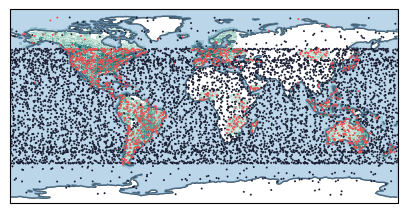

In [9]:
# Create global map
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()})
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
ax.coastlines()
ax.set_global()

# Add ocean background
ocean_feature = cfeature.NaturalEarthFeature(
    'physical', 'ocean', '110m',
    edgecolor='face',
    facecolor='#7BAED5',
    alpha=0.5
)
ax.add_feature(ocean_feature)

# Plot demand heatmap
sc = m.scatter(lons, lats, c=values, cmap=cmap, norm=norm, marker='s', s=5, edgecolor='none', alpha=0.75)

# Plot satellite positions
for idx, sat in enumerate(starlink_pos):
    plt.scatter(np.degrees(sat[0]), np.degrees(sat[1]), s=2, marker='o', color=color_set_starlink[idx], edgecolor='none', zorder=3)

# Save figure
plt.savefig("figure1a.pdf", bbox_inches="tight")
plt.savefig("figure1a.png", bbox_inches="tight")

# TinyLEO Figure1b

In [10]:
data_file="data/TinyLEO_for_starlink_demand.npy"
supply_data=np.load(data_file,allow_pickle=True)

In [11]:
# starlink satellite pos in one moment
oneslot_pos=[]
time_shift=0
for idx,data in enumerate(supply_data):
    param,random_numbers,sat_location,sat_num=data
    sat_pair=sat_location[time_shift]
    oneslot_pos.append(sat_pair)

In [12]:
with mp.Pool(processes=max_process) as pool:
    color_set_tinyleo = list(tqdm(pool.imap(judge_hotspts, oneslot_pos), total=len(oneslot_pos), mininterval=10,maxinterval=20))
    pool.close()  # Prevents any more tasks from being submitted to the pool
    pool.join()  # Wait for the worker processes to exit

100%|██████████| 1762/1762 [00:00<00:00, 8347.56it/s]


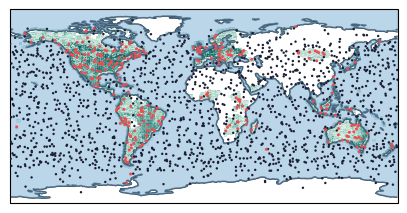

In [13]:
# Create global map
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()})
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
ax.coastlines()
ax.set_global()

# Add ocean background
ocean_feature = cfeature.NaturalEarthFeature(
    'physical', 'ocean', '110m',
    edgecolor='face',
    facecolor='#7BAED5',
    alpha=0.5
)
ax.add_feature(ocean_feature)

# Plot demand heatmap
sc = m.scatter(lons, lats, c=values, cmap=cmap, norm=norm, marker='s', s=5, edgecolor='none', alpha=0.75)

# Plot TinyLEO satellite positions with color and size based on coverage status
for idx, sat in enumerate(oneslot_pos):
    cc = color_set_tinyleo[idx]
    s = 4.5 if cc == '#EE4E4E' else 3  # Use larger size for hotspot-covered satellites
    plt.scatter(np.degrees(sat[0]), np.degrees(sat[1]), s=s, marker='o', color=color_set_tinyleo[idx], edgecolor='none', zorder=3)

# Save the figure
plt.savefig("figure1b.pdf", bbox_inches="tight")
plt.savefig("figure1b.png", bbox_inches="tight")